# Yield Curve Modeling
Objective of this notebook:

**Interpolate the Indian Yield curve using 2 techniques: ***Nielsen Siegel Svensson*** and ***Cubic Spline Interpolation***. Comparing both the techniques to better understand and evaluate**


## IMPORT LIBRARIES

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
!pip install fredapi
from fredapi import Fred


In [78]:
##IMPORT 6_month,2-year,5-year and 30-year India treasuries
## selecting time frame common for all 4 tresuries i.e, from 01-01-2009 to 31-12-2019, without NA values
# six_mnth = pd.read_csv('India 6-Month Bond Yield Historical Data.csv')#, header=None, delimiter='\t')
# two_yr =pd.read_csv('India 2-Year Bond Yield Historical Data.csv')
# five_yr =pd.read_csv('India 5-Year Bond Yield Historical Data.csv')
# thirty_yr =pd.read_csv('India 30-Year Bond Yield Historical Data.csv')
# thirty_yr['Date'] = thirty_yr['Date'].str.replace("/", "-", regex=False)
yields=pd.read_csv('India Bond Yield Historical Data.csv')
yields= yields[["Date", "six-month", "two-yr", "five-yr", "thirty-yr"]]
yields.set_index('Date', inplace=True)

In [86]:
yields.index = pd.to_datetime(yields.index,format='%d-%m-%Y')

In [87]:
yields.index.sort_values()

DatetimeIndex(['2008-01-02', '2008-01-07', '2008-01-08', '2008-01-09',
               '2008-01-10', '2008-02-01', '2008-02-04', '2008-02-05',
               '2008-02-06', '2008-02-07',
               ...
               '2019-12-03', '2019-12-04', '2019-12-06', '2019-12-09',
               '2019-12-12', '2020-01-01', '2020-06-01', '2020-07-01',
               '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', name='Date', length=875, freq=None)

In [88]:
yields.index.min(), yields.index.max()

(Timestamp('2008-01-02 00:00:00'), Timestamp('2020-10-01 00:00:00'))

In [89]:
print(yields.head())
print(yields.shape)
print(yields.info())
print(yields.tail())

            six-month  two-yr  five-yr  thirty-yr
Date                                             
2009-01-01       4.60   5.047    5.380      6.364
2010-01-01       4.10   5.539    7.241      8.337
2013-01-01       8.09   7.788    7.989      8.222
2014-01-01       8.80   8.665    8.948      9.269
2015-01-01       8.35   7.879    8.028      8.035
(875, 4)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 875 entries, 2009-01-01 to 2019-12-12
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   six-month  875 non-null    float64
 1   two-yr     875 non-null    float64
 2   five-yr    875 non-null    float64
 3   thirty-yr  875 non-null    float64
dtypes: float64(4)
memory usage: 34.2 KB
None
            six-month  two-yr  five-yr  thirty-yr
Date                                             
2013-12-12       8.85   8.473    8.921      9.359
2014-12-12       8.28   7.789    7.886      7.900
2017-12-12       6.22   6.612   

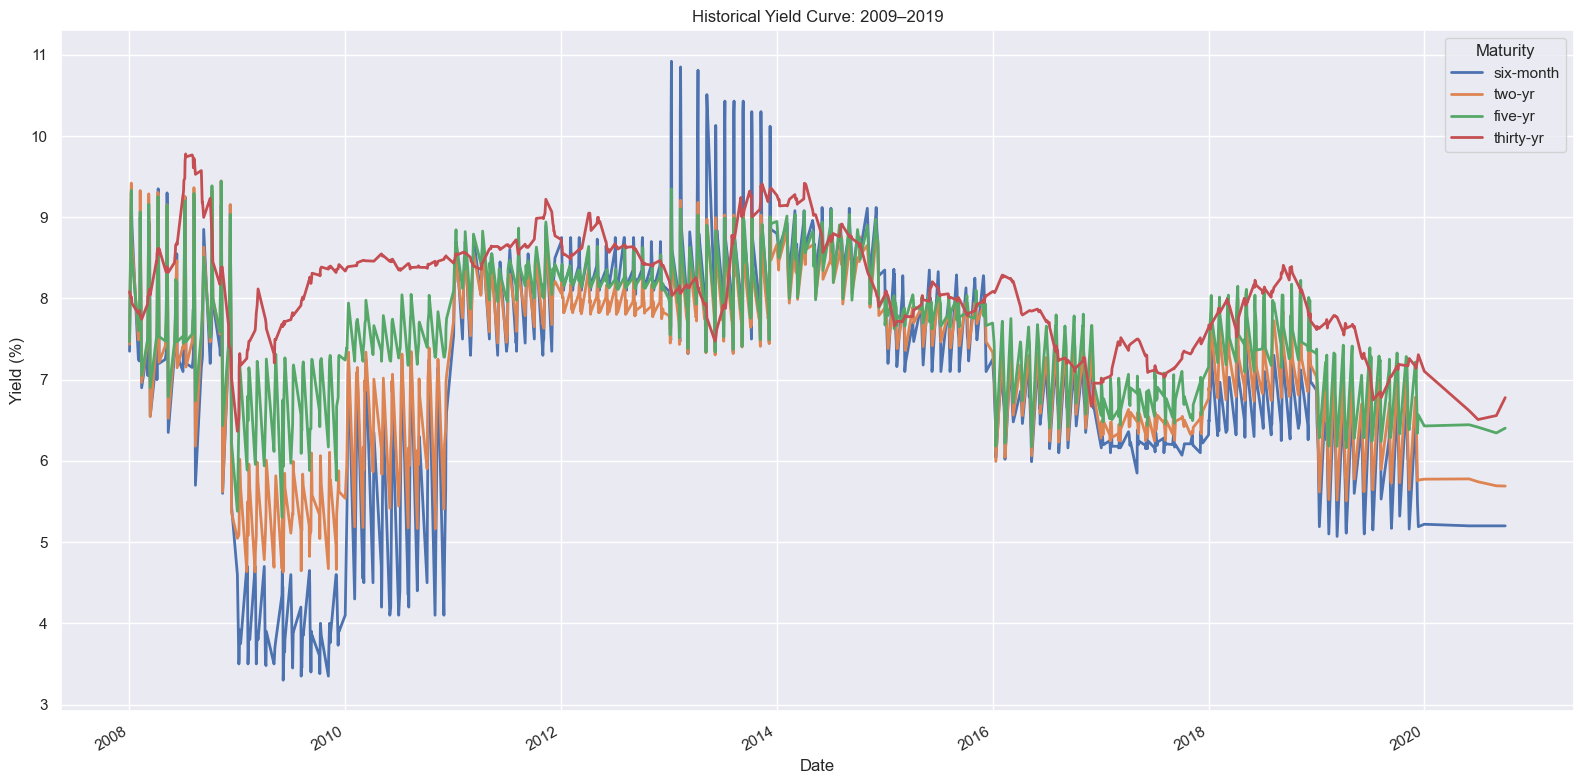

In [90]:
##figure 1
yields.plot(figsize=(16, 8), linewidth=2)
plt.title("Historical Yield Curve: 2009–2019")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.grid(True)
plt.legend(title="Maturity")
plt.tight_layout()
plt.show()

C:\Users\Apratim Narayan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Apratim Narayan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Apratim Narayan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Apratim Narayan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

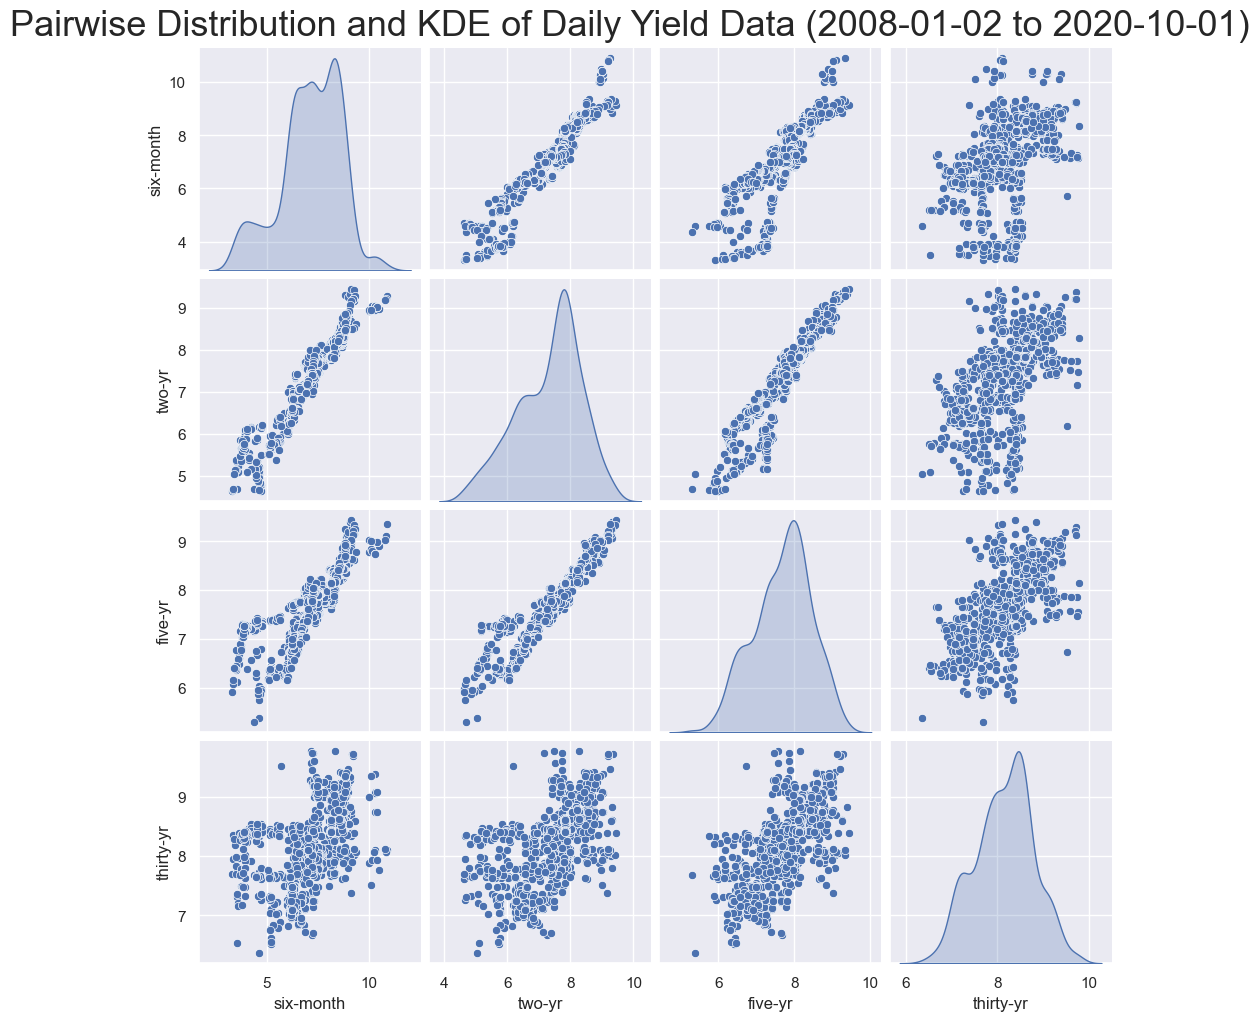

In [91]:
##visualizing the interdependence
import matplotlib.pyplot as plt
sns.pairplot(yields, diag_kind='kde') # Pairplot with KDE on the diagonal
plt.suptitle("Pairwise Distribution and KDE of Daily Yield Data (2008-01-02 to 2020-10-01)",
             y=1.02, fontsize=26)
plt.show()

**We see 2-yr and 6-month highly correlated and 2-yr and 5-yr also correlated.**

In [92]:
pip install nelson_siegel_svensson

**Nielsen Siegel Svensson**
$$
y(t) = \beta_0 + \beta_1 \cdot \left( \frac{1 - e^{-t/\tau_1}}{t/\tau_1} \right) + \beta_2 \cdot \left( \frac{1 - e^{-t/\tau_1}}{t/\tau_1} - e^{-t/\tau_1} \right) + \beta_3 \cdot \left( \frac{1 - e^{-t/\tau_2}}{t/\tau_2} - e^{-t/\tau_2} \right)
$$


NSS is used for curve modeling, as we observe correlation between 2-yr and 6-month Indian treasuries is high, similarly for 2-yr and 5-yr. NSS adds a second curvature term compared to conventional NS,allowing for more nonlinearty.
$$\beta_3 \cdot \left( \frac{1 - e^{-t/\tau_2}}{t/\tau_2} - e^{-t/\tau_2} \right)$$


where 
- Adds $\beta_3$ and $\tau_2$ to enhance flexibility
- $\beta_3$ second curvature term
- $\tau_2$ second decay factor

In [93]:
# Import the packages for fitting NS model
from nelson_siegel_svensson.calibrate import calibrate_ns_ols

In [100]:
# Create maturity and yield variables in array form
t = np.array([0.5,2,5,30])


In [101]:
y = np.array(yields.loc[pd.Timestamp("2020-10-01")])
y

array([5.2  , 5.69 , 6.403, 6.779])

In [102]:
# Fit an NS model for yields from 2020-01-10
curve, status = calibrate_ns_ols(t, y, tau0=1.0)  # starting value of 1.0 for the optimization of tau
assert status.success
print(curve)

NelsonSiegelCurve(beta0=6.8623534319760084, beta1=170.49644285321872, beta2=-189.99052606062406, tau=0.11997145732324713)


Considering a fixed value of $\tau$ = 1.0, meaning the starting point is 1 and then the function would optimize using OLS. Smaller $\tau$ means faster decay and vice versa.

**Interesting thing to note here even though we are relying on linear estimates, $\beta$, but the equation is non linear in $\tau$.**

**output for Nelson Siegel Curve**<br />
NelsonSiegelCurve(beta0=6.8623534319760084, beta1=170.49644285321872, beta2=-189.99052606062406, tau=0.11997145732324713)

Text(0.5, 1.0, 'Figure , NSS Model Result')

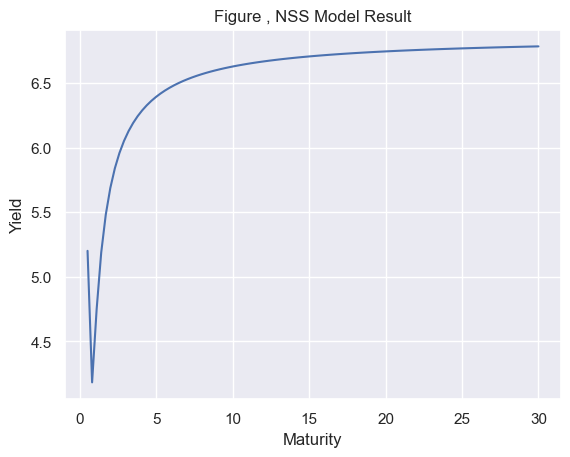

In [103]:
y_hat = curve
t_hat = np.linspace(0.5,30,100)
plt.plot(t_hat, y_hat(t_hat))
plt.xlabel("Maturity")
plt.ylabel("Yield")
plt.title("Figure , NSS Model Result")

**Fitting for 2020-10-01 using the estimates obtained from NSS**

In [80]:
print(yields.index[:10])  # First few entries
print(yields.index[-10:]) # Last few entries

Index(['01-01-2009', '01-01-2010', '01-01-2013', '01-01-2014', '01-01-2015',
       '01-01-2016', '01-01-2018', '01-01-2019', '01-01-2020', '01-02-2008'],
      dtype='object', name='Date')
Index(['12-11-2014', '12-11-2018', '12-12-2008', '12-12-2011', '12-12-2012',
       '12-12-2013', '12-12-2014', '12-12-2017', '12-12-2018', '12-12-2019'],
      dtype='object', name='Date')


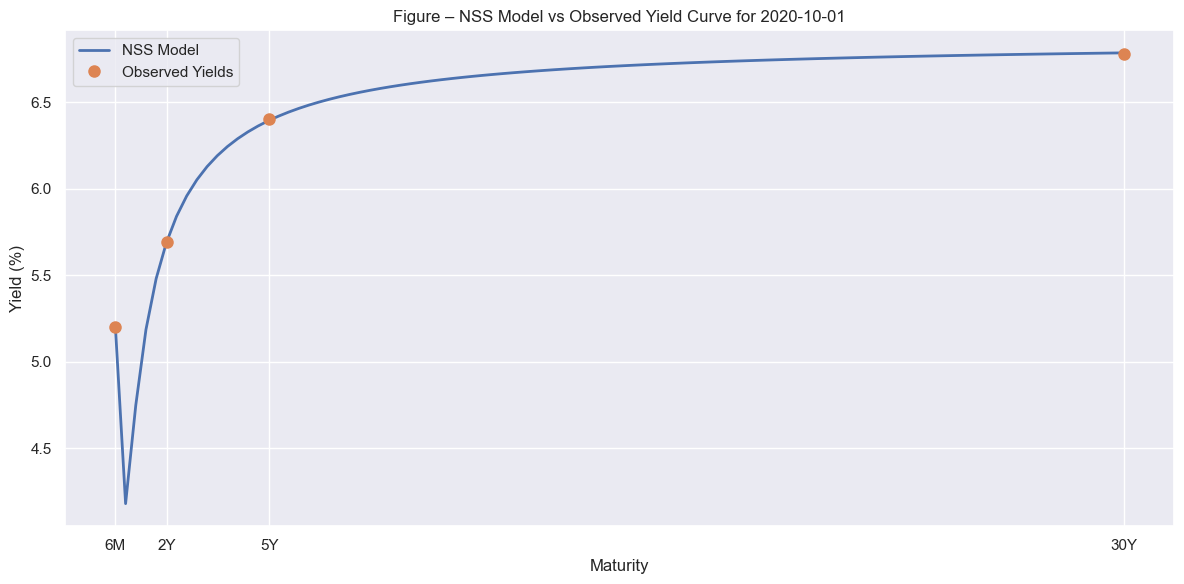

In [104]:
# Define maturities corresponding to observed yields (in years)
maturities_obs = [0.5, 2, 5, 30]  # 6M, 2Y, 5Y, 30Y
maturity_labels = ['6M', '2Y', '5Y', '30Y']

# Extract observed yields for a specific date
date = pd.Timestamp("2020-10-01") # or use datetime object if index is datetime
observed_yields = yields.loc[date].values  # assumes yields is your DataFrame

# Generate NSS curve
t_hat = np.linspace(0.5, 30, 100)
nss_yields = curve(t_hat)  # curve is your fitted NSS model

# Plot both
plt.figure(figsize=(12, 6))
plt.plot(t_hat, nss_yields, label='NSS Model', linewidth=2)
plt.plot(maturities_obs, observed_yields, 'o', label='Observed Yields', markersize=8)

# Labels and formatting
plt.xticks(maturities_obs, maturity_labels)
plt.xlabel("Maturity")
plt.ylabel("Yield (%)")
plt.title("Figure – NSS Model vs Observed Yield Curve for 2020-10-01")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Cubic Spline

Comparing NSS curve fitting with Cubic Spline. 

Cubic spline is a non parametric technique which highly flexible but not as much stable as NSS. General equation below:
$$
f(x) = a_1 x^3 + b_1 x^2 + c_1 x + d_1, \quad x_0 \leq x \leq x_1
$$
In this case there would be 4 cubic equations, one for each maturity, the coefficients would be calculated and used to interpolate.

In [108]:
## this may 2020, 2 months post first lockdown experienced in India
# we observed convergence of yields, as in decrease in spread
yields.loc[pd.Timestamp("2020-06-01")]

six-month    5.200
two-yr       5.778
five-yr      6.445
thirty-yr    6.618
Name: 2020-06-01 00:00:00, dtype: float64

In [109]:
t = np.array([0.5,2,5,30])
y = yields.loc[pd.Timestamp("2020-06-01")]

In [110]:
# Create output vector y (out variable) and squared matrix A (input variable)
out = np.array([5.200,5.778,5.778,6.445,6.445,6.618,0,0,0,0,0,0])
input = np.array([[0.125,0.25,0.5,1,0,0,0,0,0,0,0,0],[8,4,2,1,0,0,0,0,0,0,0,0],[0,0,0,0,8,4,2,1,0,0,0,0],[0,0,0,0,125,25,5,1,0,0,0,0], \
                  [0,0,0,0,0,0,0,0,125,25,5,1],[0,0,0,0,0,0,0,0,27000,900,30,1],[12,4,1,0,-12,-4,-1,0,0,0,0,0],[0,0,0,0,75,10,1,0,-75,-10,-1,0], \
                  [12,2,0,0,-12,-2,0,0,0,0,0,0],[0,0,0,0,30,2,0,0,-30,-2,0,0],[3,2,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,180,2,0,0]])

In [111]:
# Solve for coefficient vector and reshape to an 3 by 4 array (lines variable)
# Make sure to give enough decimals since all coefficients are relatively small. If there is not decimal points, the following coefficient results and graphs will be rough
lines = np.round(np.dot(np.linalg.inv(input), out).reshape(-1,4),decimals=8)
lines

array([[-1.14232500e-02,  1.71348700e-02,  4.02468200e-01,
         4.99591009e+00],
       [ 4.73538000e-03, -7.98168900e-02,  5.96371720e-01,
         4.86664108e+00],
       [ 1.17150000e-04, -1.05434200e-02,  2.50004360e-01,
         5.44392000e+00]])

In [112]:
# Calculates x**0 + x**1 + x**2 + x**3
def plot_num(values, coeffs):
    # Coeffs are assumed to be in order 0, 1, ..., n-1
    expanded = np.hstack([coeffs[i] * (values ** i) for i in range(0, len(coeffs))])
    return np.sum(expanded, axis=1)


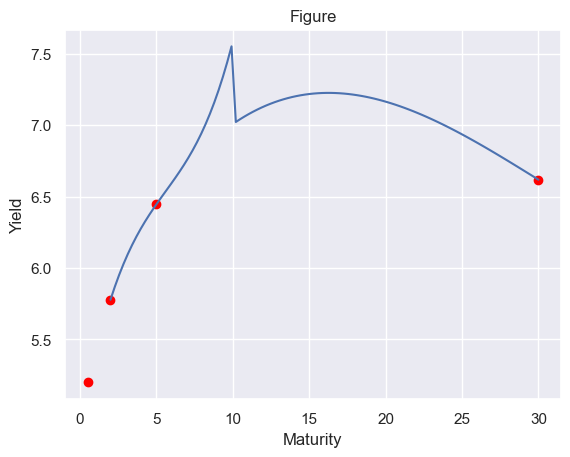

In [113]:
# Simulate the 100 paired data points and draw the graph
xs = np.linspace(2,30, 100)

y1s = plot_num(xs[xs<2].reshape(-1,1), lines[0][::-1])
y2s = plot_num(xs[(xs>=2) & (xs<10)].reshape(-1,1), lines[1][::-1])
y3s = plot_num(xs[xs>=10].reshape(-1,1), lines[2][::-1])
ys = np.concatenate([y1s, y2s, y3s])


plt.plot(xs, ys)
plt.scatter(t, y,c="red")
plt.xlabel("Maturity")
plt.ylabel("Yield")
plt.title("Figure")
plt.show()


In [125]:
lines

array([[-1.14232500e-02,  1.71348700e-02,  4.02468200e-01,
         4.99591009e+00],
       [ 4.73538000e-03, -7.98168900e-02,  5.96371720e-01,
         4.86664108e+00],
       [ 1.17150000e-04, -1.05434200e-02,  2.50004360e-01,
         5.44392000e+00]])

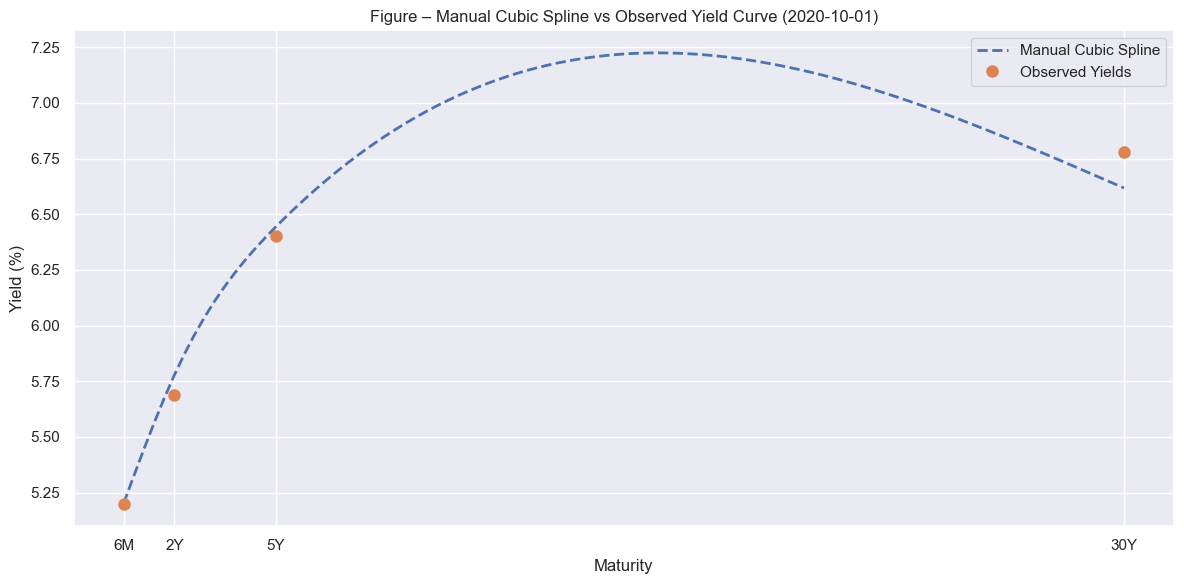

In [126]:
# Define observed maturities and labels
maturities_obs = [0.5, 2, 5, 30]  # in years
maturity_labels = ['6M', '2Y', '5Y', '30Y']

# Extract observed yields for a specific date
date = pd.Timestamp("2020-10-01")
observed_yields = yields.loc[date].values

# Define evaluation points
t_hat = np.linspace(0.5, 30, 100)

# Define manual spline evaluator
def manual_cubic_spline(t):
    if 0.5 <= t < 2:
        a, b, c, d = lines[0]
    elif 2 <= t < 5:
        a, b, c, d = lines[1]
    elif 5 <= t <= 30:
        a, b, c, d = lines[2]
    else:
        return np.nan
    return a*t**3 + b*t**2 + c*t + d

# Evaluate spline across t_hat
spline_yields = [manual_cubic_spline(t) for t in t_hat]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(t_hat, spline_yields, label='Manual Cubic Spline', linestyle='--', linewidth=2)
plt.plot(maturities_obs, observed_yields, 'o', label='Observed Yields', markersize=8)

plt.xticks(maturities_obs, maturity_labels)
plt.xlabel("Maturity")
plt.ylabel("Yield (%)")
plt.title("Figure – Manual Cubic Spline vs Observed Yield Curve (2020-10-01)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Define the 4 maturities
maturities_obs = [0.5, 2, 5, 30]

# Evaluate NSS curve at these points
nss_yields_4pts = curve(np.array(maturities_obs))

# Print results
for t, y in zip(maturities_obs, nss_yields_4pts):
    print(f"NSS yield at {t}Y: {y:.6f}%")

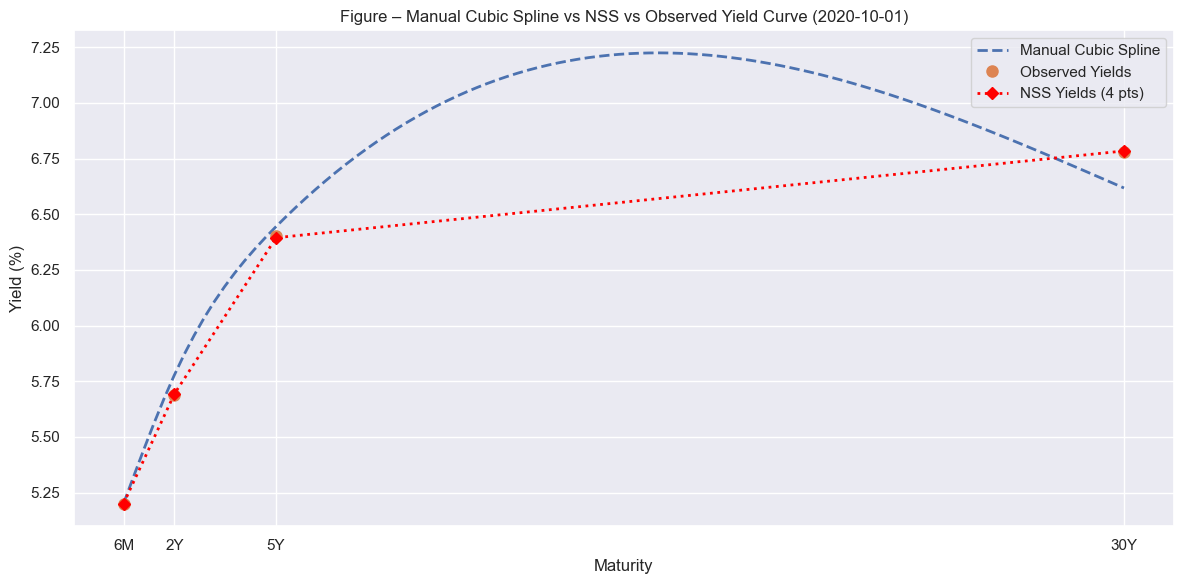

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define observed maturities and labels
maturities_obs = [0.5, 2, 5, 30]  # in years
maturity_labels = ['6M', '2Y', '5Y', '30Y']

# Extract observed yields for a specific date
date = pd.Timestamp("2020-10-01")
observed_yields = yields.loc[date].values

# Define evaluation points
t_hat = np.linspace(0.5, 30, 100)

# Define manual spline evaluator
def manual_cubic_spline(t):
    if 0.5 <= t < 2:
        a, b, c, d = lines[0]
    elif 2 <= t < 5:
        a, b, c, d = lines[1]
    elif 5 <= t <= 30:
        a, b, c, d = lines[2]
    else:
        return np.nan
    return a*t**3 + b*t**2 + c*t + d

# Evaluate spline across t_hat
spline_yields = [manual_cubic_spline(t) for t in t_hat]

# Evaluate NSS curve at 4 observed maturities
nss_yields_4pts = curve(np.array(maturities_obs))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(t_hat, spline_yields, label='Manual Cubic Spline', linestyle='--', linewidth=2)
plt.plot(maturities_obs, observed_yields, 'o', label='Observed Yields', markersize=8)
plt.plot(maturities_obs, nss_yields_4pts, 'D', label='NSS Yields (4 pts)', color='red', linestyle=':', linewidth=2)

plt.xticks(maturities_obs, maturity_labels)
plt.xlabel("Maturity")
plt.ylabel("Yield (%)")
plt.title("Figure – Manual Cubic Spline vs NSS vs Observed Yield Curve (2020-10-01)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

NSS fits much better than cubic spline, espically for the longer maturity.